In [66]:
import pandas as pd
import json
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [67]:
colnames=['tweets', 'created_at', 'id', 'rt', 'lang', 'urls', 'Event']
df_relevant = pd.read_csv('clean_relevant_tweets.csv', header='infer')
df_clusters = pd.read_csv('temp23_8.csv',header='infer',engine='python')


colnames=['tweets', 'created_at', 'id', 'rt', 'lang', 'urls'] 
df_irrelevant = pd.read_csv('output_irrelevant_nocord.csv', names=colnames, header=None)
frames = [df_relevant,df_irrelevant]
df = pd.concat(frames)
df = df.loc[df["lang"]=='en']


import timestamp_graphs as tg
df = df.reset_index(drop=True)
df = tg.createTimestamps(df)

list_date_minutes = tg.getList(df,'Datetime')
print(len(list_date_minutes))

39949


In [68]:
temp_clusters = df_clusters.loc[df_clusters.Event==5]
temp_count = temp_clusters.groupby(["Cluster"]).count()
array = temp_count.loc[temp_count.tweets!=1].index.tolist()

In [69]:
def getLabel(list_event):
    try:
        temp = list_event.value_counts()
        return temp.keys()[0]
    except:
        return -1

def findPurity(temp_df):
    try:
        label = getLabel(temp_df['Event'])
        n1 = temp_df.loc[temp_df['Event']==label].shape[0]
        n2 = temp_df.shape[0]
        return n1/n2
    except:
        return -1

def getDataframePurity(df,list_predict):
    df_purity = pd.DataFrame()
    df_purity['Cluster'] = np.array([cluster for cluster in list_predict])
#     print(df_purity['Cluster'])
    df_purity['Length_Cluster'] = [df.loc[df.Cluster==temp].shape[0] for temp in df_purity['Cluster']]
    df_purity['Predicted_Event'] = np.array([int(getLabel(df.loc[df['Cluster']==cluster]['Event'])) for cluster in list_predict])
    df_purity['Purity'] = np.array([round(findPurity(df.loc[df['Cluster']==cluster]),1) for cluster in list_predict])
    return df_purity

In [70]:
df_purity = getDataframePurity(temp_clusters,array)

In [71]:
df_purity.shape[0]

38

In [72]:
df_purity.groupby(['Length_Cluster']).count()

,Cluster,Predicted_Event,Purity
Length_Cluster,,,
2,1,1,1
5,2,2,2
6,13,13,13
8,3,3,3
9,1,1,1
10,9,9,9
11,2,2,2
19,1,1,1
20,1,1,1


In [73]:
import nltk
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
stopword = nltk.corpus.stopwords.words('english')
# Stemming is the process of breaking a word down into its root.
stemmer = SnowballStemmer('english')
stops = set(stopwords.words("english"))
import data_preprocessing_methods as dpm

In [74]:
import collections

def findTopFeatures(temp_df, attribute):
    list_terms = []
    for i in range(temp_df.shape[0]):
        temp_terms = temp_df.iloc[i][attribute]
        for current_terms in temp_terms:
            list_terms.append(current_terms)
    
    counter = collections.Counter(list_terms)
    crucial_words = counter.most_common(3)
    final_list = []
    for i in range(len(crucial_words)):
                final_list.append(crucial_words[i][0])
    return final_list

In [75]:
def createTitle(df_clusters,list_cluster):
    list_rows = []
    for temp_cluster in list_cluster:
        temp_df = df_clusters.loc[df_clusters.Cluster==temp_cluster]
        temp = np.vectorize(dpm.remove_patterns)(temp_df['tweets'],"@[\w]*","#[\w]*","RT")
        temp_df["text"] = np.array([text["input_text"] for text in temp])
        temp_df["hashtag"] = [dpm.list_lower(text["hashtags"]) for text in temp]
        temp_df["user_mentions"] = [text["user_mentions"] for text in temp] 
        temp_df["RT"] = [text["is_RT"] for text in temp]
        temp_df["URL"] = [text["is_URL"] for text in temp]
        
        top_hashtags = findTopFeatures(temp_df,'hashtag')
        top_user_mentions = findTopFeatures(temp_df,'user_mentions')
        top_URLs = findTopFeatures(temp_df,'URL')
        
        temp_df['Tweet_punct'] = temp_df['text'].apply(lambda x: dpm.remove_punct(x))
        temp_df['Tweet_tokenized'] = temp_df['Tweet_punct'].apply(lambda x: dpm.tokenization(x.lower()))
        temp_df['Tweet_nonstop'] = temp_df['Tweet_tokenized'].apply(lambda x: dpm.remove_stopwords(x,stopword))
        temp_df["Stem_sent"] = [dpm.stemming_to_sent(temp,stemmer) for temp in temp_df["Tweet_nonstop"]]
        temp_df["Stem_words"] = [dpm.stemming_to_words(temp,stemmer) for temp in temp_df["Tweet_nonstop"]]
        
        temp_df['urls'] = 'None'
        list_index = temp_df.index.tolist()
        temp_df["clean_data"] = [dpm.new_clean_data(i,temp_df) for i in list_index]
        
#         trainContent = temp_df.clean_data
        trainContent = temp_df.Stem_sent
        from sklearn.feature_extraction.text import CountVectorizer

        headline_vectorizer = CountVectorizer(binary=True,min_df=0.1,ngram_range=(1,1))
        X = headline_vectorizer.fit_transform(trainContent)
        
        max_vector = 0
        for i in range(X.shape[0]):
            count_words = X[i].count_nonzero()
            shape = len(temp_df.Tweet_nonstop.iloc[i])
#             shape = len(temp_df.clean_data.iloc[i])
            if(shape!=0):
                ratio = count_words/shape
                if (ratio>max_vector):
                    max_vector = ratio
                    max_index = i

        title = temp_df.tweets.iloc[max_index]
        cluster_length = temp_df.shape[0]
        timestamp = temp_df.loc[temp_df['Cluster']==temp_cluster].iloc[0]['Timestamp']
#         event = temp_df.loc[temp_df['Cluster']==temp_cluster].iloc[0]['Event']
        event = df_purity.loc[df_purity.Cluster==temp_cluster].iloc[0]['Predicted_Event']
        purity = df_purity.loc[df_purity.Cluster==temp_cluster].iloc[0]['Purity']
        topic = headline_vectorizer.get_feature_names()
        
        temp_row = [title,timestamp,temp_cluster,cluster_length,int(event),purity,topic,
                    top_hashtags,top_user_mentions,top_URLs]
#         print(temp_row)
        list_rows.append(temp_row)
    return list_rows

In [76]:
temp_list = createTitle(temp_clusters,array)

In [77]:
summarize_clusters =pd.DataFrame(temp_list,columns=['Title','Timestamp','Cluster','Length','Event','Purity','Topic','Top_Hashtags','Top_Mentions','top_URLs'])

In [78]:
summarize_clusters['Date'] = np.array([list_date_minutes[temp+9] for temp in summarize_clusters['Timestamp']])

In [79]:
extract_clusters = pd.DataFrame()
extract_clusters['Cluster'] = summarize_clusters['Cluster']
extract_clusters['Time'] = summarize_clusters['Date']
extract_clusters['Title'] = summarize_clusters['Title']
extract_clusters['Keywords'] = summarize_clusters['Topic']
extract_clusters['Top_Hashtags'] = summarize_clusters['Top_Hashtags']
extract_clusters['Top_Mentions'] = summarize_clusters['Top_Mentions']
extract_clusters['Top_URLs'] = summarize_clusters['top_URLs']
extract_clusters['Number_of_Tweets'] = summarize_clusters['Length']
extract_clusters['Purity'] = summarize_clusters['Purity']
extract_clusters['Event'] = summarize_clusters['Event']

In [81]:
extract_clusters

,Cluster,Time,Title,Keywords,Top_Hashtags,Top_Mentions,Top_URLs,Number_of_Tweets,Purity,Event
0,650,2012-10-15 20:08:00,Ray Lewis out for the year. Torn tricep.,"[damn, lewi, ray, torn, tricep, webb, wow, year]",[#heartbroken],[],[],9,1.0,5
1,651,2012-10-15 20:08:00,Ray Lewis done for the year. Wow,"[done, lewi, ray, wow, year]",[#fuck],[],[],8,1.0,5
2,652,2012-10-15 20:10:00,damn Lewis and webb out for the season,"[bit, dagger, damn, lewi, ray, season, webb, w...",[],[],[],5,1.0,5
3,653,2012-10-15 20:12:00,Ray Lewis done for the year #Wamp,"[career, damn, done, lewi, mayb, ray, season, ...","[#ravens, #wamp, #guysalegend]","[@AdamSchefter, @SportsCenter, @Ravens]",[],128,1.0,5
4,654,2012-10-15 20:12:00,Ray Lewis out for the year!? Ravens are beat,"[beat, best, dag, damn, defens, end, final, fo...","[#nfl, #ravens, #goat]",[],[],19,1.0,5
5,655,2012-10-15 20:16:00,Ray Lewis and Lardarius Webb out for the seaso...,"[ass, battl, lardarius, lewi, raven, ray, rest...",[#ravens],[],[],6,1.0,5
6,656,2012-10-15 20:16:00,Complete Tricep Tear Ray Lewis done for the ye...,"[complet, done, forev, fuck, go, harsh, lewi, ...",[],[],[http://t.co/KfgwmZeH],10,1.0,5
7,657,2012-10-15 20:16:00,“@AdamSchefter: Ray Lewis torn tricep - out fo...,"[break, career, damn, lewi, mayb, ray, season,...","[#whatsgoingon, #footballfantasy, #52]","[@AdamSchefter, @SportsCenter, @tgillionaire]",[],54,1.0,5
8,658,2012-10-15 20:17:00,Webb and Lewis are both out for the year. Fuck...,"[ass, back, believ, cant, fuck, good, jail, le...","[#ravens, #fuck]",[@Trill_Skywalker],[],11,1.0,5
9,659,2012-10-15 20:19:00,ray lewis career might be over? woah,"[accord, career, dang, espn, lewi, might, ray,...",[#rds],[],[http://t.co/4CYTjdVV],6,1.0,5


In [16]:
# extract_clusters.loc[extract_clusters.Number_of_Tweets>5]

In [17]:
# for index,row in extract_clusters.iterrows():
#     print(row.Time,row.Title,row.Keywords,row.Number_of_Tweets)

In [18]:
# extract_clusters.to_csv("TopicAnalysis.csv",index=True)

In [19]:
extract_clusters_2 = pd.DataFrame()
extract_clusters_2['Cluster'] = summarize_clusters['Cluster']
extract_clusters_2['Top_Hashtags'] = summarize_clusters['Top_Hashtags']
extract_clusters_2['Top_Mentions'] = summarize_clusters['Top_Mentions']
extract_clusters_2['Top_URLs'] = summarize_clusters['top_URLs']

In [ ]:
# extract_clusters_2.to_csv("TopicAnalysis_2.csv",index=True)

# Irrelevant Clusters Analysis

In [82]:
irrelevant_clusters = df_clusters.loc[df_clusters.Event==-1]
array = irrelevant_clusters.groupby(["Cluster"]).count().index.tolist()

In [83]:
temp = irrelevant_clusters.groupby(['Cluster']).count()
irrelevant_length = temp.loc[temp.tweets!=1]

In [84]:
irrelevant_length.groupby(['tweets']).count()

,Timestamp,Event
tweets,,
2,33,33
3,14,14
4,4,4
5,85,85
6,10,10
8,2,2


# Upper Irrelevant Clusters Analysis

In [85]:
irrelevant_clusters = df_clusters.loc[df_clusters['Event']==-1]

In [86]:
temp_count = irrelevant_clusters.groupby(["Cluster"]).count()
upper_count = temp_count.loc[temp_count.tweets>=10]
upper_array = upper_count.loc[upper_count.tweets!=1].index.tolist()

In [87]:
def getFrequentWords(irrelevant_clusters,upper_array):
    list_words = []
    for temp_cluster in upper_array:
        temp_df = irrelevant_clusters.loc[irrelevant_clusters.Cluster==temp_cluster]
        temp = np.vectorize(dpm.remove_patterns)(temp_df['tweets'],"@[\w]*","#[\w]*","RT")
        temp_df["text"] = np.array([text["input_text"] for text in temp])
        temp_df['Tweet_punct'] = temp_df['text'].apply(lambda x: dpm.remove_punct(x))
        temp_df['Tweet_tokenized'] = temp_df['Tweet_punct'].apply(lambda x: dpm.tokenization(x.lower()))
        temp_df['Tweet_nonstop'] = temp_df['Tweet_tokenized'].apply(lambda x: dpm.remove_stopwords(x,stopword))
        temp_df["Stem_words"] = [dpm.stemming_to_words(temp,stemmer) for temp in temp_df["Tweet_nonstop"]]
        for i in range(temp_df.shape[0]):
            temp_list = temp_df.iloc[i]['Stem_words']
            for word in temp_list:
                list_words.append(word)
    return list_words

In [88]:
upper_list = getFrequentWords(irrelevant_clusters,upper_array)

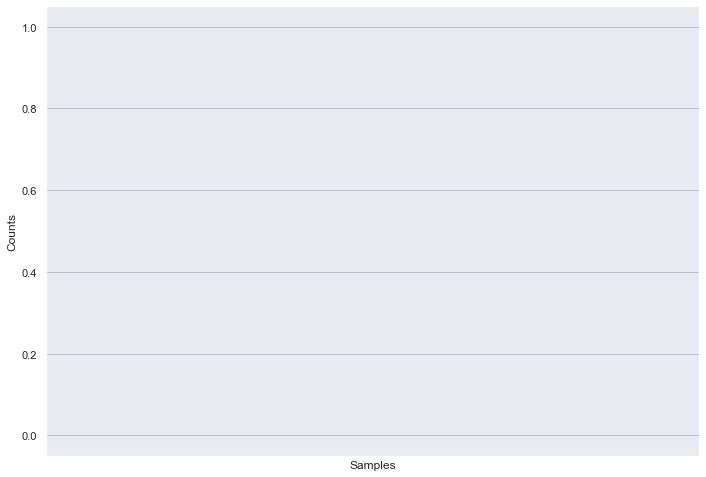

In [89]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_style('darkgrid')

nlp_words = nltk.FreqDist(upper_list)
nlp_words.plot(50)

In [90]:
temp_list = createTitle(temp_clusters,upper_array)

In [91]:
summarize_clusters_upward = pd.DataFrame(temp_list,columns=['Title','Timestamp','Cluster','Length','Event','Purity','Topic','Top_Hashtags','Top_Mentions','top_URLs'])
summarize_clusters_upward['Date'] = np.array([list_date_minutes[temp+9] for temp in summarize_clusters_upward['Timestamp']])

In [92]:
summarize_clusters_upward.head()

,Title,Timestamp,Cluster,Length,Event,Purity,Topic,Top_Hashtags,Top_Mentions,top_URLs,Date


# Downwards Irrelevant Cluster Analysis

In [93]:
downward_count = temp_count.loc[temp_count.tweets<=6]
downward_array = downward_count.loc[downward_count.tweets!=1].index.tolist()

In [94]:
downward_list = getFrequentWords(irrelevant_clusters,downward_array)

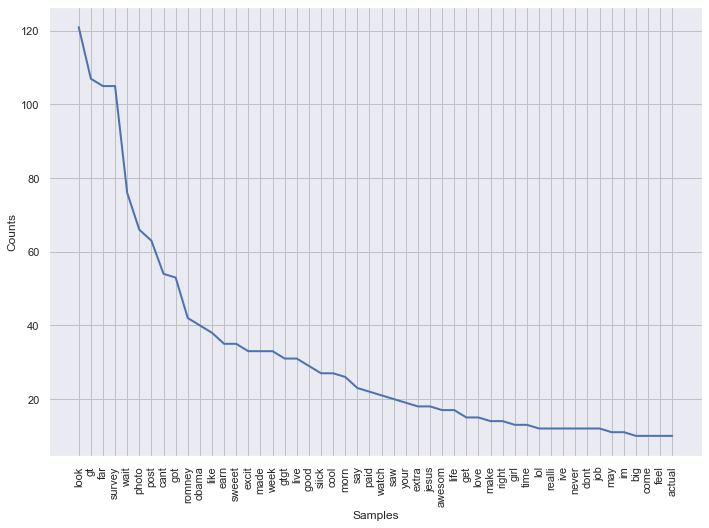

In [95]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_style('darkgrid')

nlp_words = nltk.FreqDist(downward_list)
nlp_words.plot(50)